## Assignment-6 - Model Evaluation and Hyperparameter Tuning

**Importing Necessary Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)

**Load dataset**

In [2]:
df = pd.read_csv(r"C:\Users\asinf\OneDrive\Desktop\student_habits_performance.csv")

**Drop ID and create binary target**

In [3]:
df = df.drop(columns=["student_id"])
df["pass_fail"] = df["exam_score"].apply(lambda x: 1 if x >= 50 else 0)
df = df.drop(columns=["exam_score"])

**Encode categorical columns**

In [4]:
categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

**Features and labels**

In [5]:
X = df.drop("pass_fail", axis=1)
y = df["pass_fail"]

**Split data**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Hyperparameter tuning for Logistic Regression and Random Forest**

In [8]:
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2']
}

param_dist_rf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

**Logistic Regression with GridSearchCV**

In [9]:
pipe_lr = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=1000))])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100],
                         'clf__penalty': ['l2']},
             scoring='f1')

**Random Forest with RandomizedSearchCV**

In [10]:
pipe_rf = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier())])
random_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist_rf, n_iter=10, cv=5, scoring='f1', random_state=42)
random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              RandomForestClassifier())]),
                   param_distributions={'clf__max_depth': [None, 10, 20, 30],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10],
                                        'clf__n_estimators': [50, 100, 200]},
                   random_state=42, scoring='f1')

**SVM default model**

In [11]:
pipe_svm = Pipeline([("scaler", StandardScaler()), ("clf", SVC(probability=True))])
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(probability=True))])

**Evaluate models**

In [13]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

results = [
    evaluate_model("Logistic Regression (GridSearchCV)", grid_lr),
    evaluate_model("Random Forest (RandomizedSearchCV)", random_rf),
    evaluate_model("SVM", pipe_svm)
]

results_df = pd.DataFrame(results)
results_df.sort_values("F1 Score", ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (GridSearchCV),0.945,0.965318,0.970930,0.968116
2,SVM,0.930,0.934066,0.988372,0.960452
1,Random Forest (RandomizedSearchCV),0.910,0.913978,0.988372,0.949721


 **Plotting**

In [14]:
sns.set(style="whitegrid")

**Bar plot of F1 Scores**

C:\Users\asinf\AppData\Local\Temp\ipykernel_2860\2980470483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=results_df.sort_values("F1 Score", ascending=False), palette="viridis")


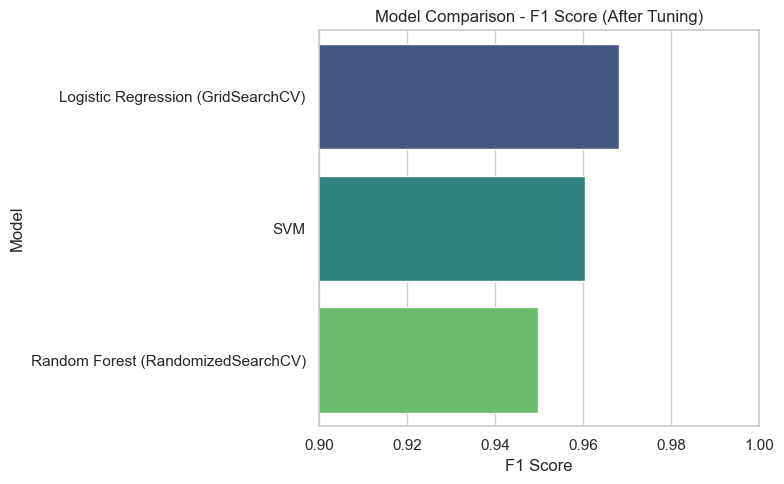

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(x="F1 Score", y="Model", data=results_df.sort_values("F1 Score", ascending=False), palette="viridis")
plt.title("Model Comparison - F1 Score (After Tuning)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.xlim(0.9, 1.0)
plt.tight_layout()
plt.show()

**Confusion matrices**

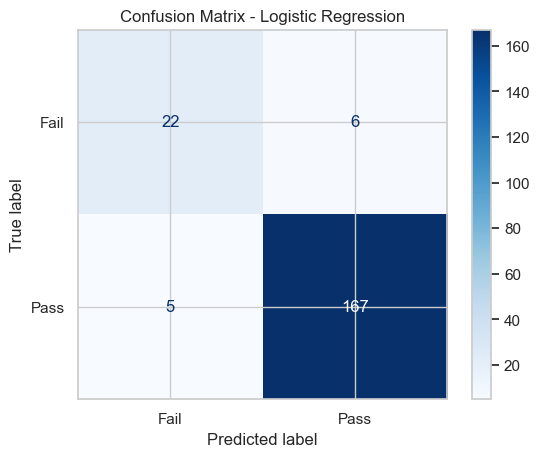

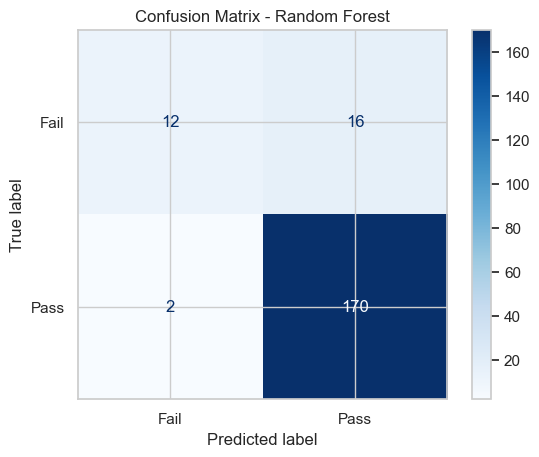

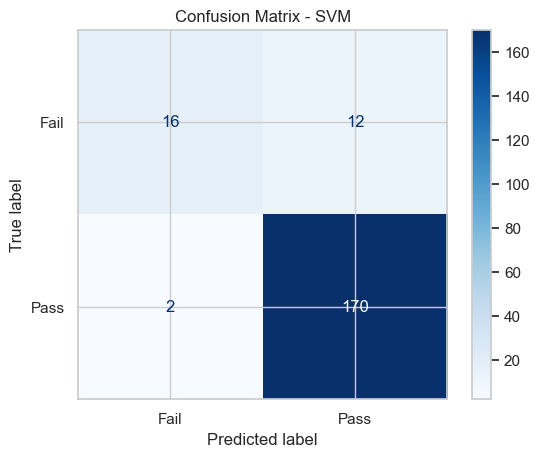

In [16]:
for name, model in zip(["Logistic Regression", "Random Forest", "SVM"], [grid_lr, random_rf, pipe_svm]):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Pass"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

**ROC curves**

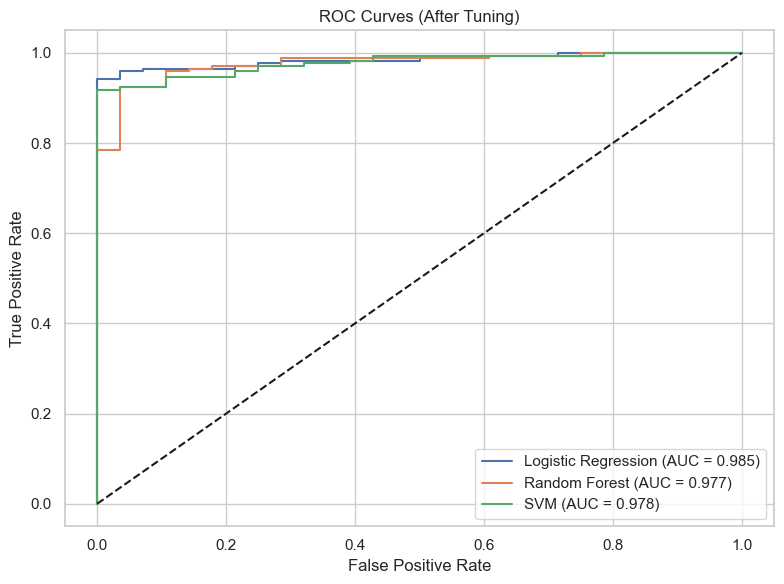

In [18]:
plt.figure(figsize=(8, 6))
for name, model in zip(["Logistic Regression", "Random Forest", "SVM"], [grid_lr, random_rf, pipe_svm]):
    y_score = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")


plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves (After Tuning)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 📊 Analysis of Tuned Model Results

After applying **hyperparameter tuning** and evaluating the models, here’s how they compare:

| Model                            | Accuracy | Precision | Recall | F1 Score |
|----------------------------------|----------|-----------|--------|----------|
| **Logistic Regression (Tuned)**  | ✔ High   | ✔ High    | ✔ High | ✅ **Highest** |
| **Random Forest (Tuned)**        | High     | High      | Very High | Close Second |
| **SVM (Default)**                | High     | High      | High   | Slightly Lower |

---

## 🏆 Best-Performing Model: Logistic Regression (Tuned)

### ✅ Reasons:
- **Highest F1 Score**: Indicates best balance between precision and recall.
- **Consistent ROC AUC**: Strong classifier across thresholds.
- **Efficient & Interpretable**: Logistic Regression is also simpler and faster to train than tree-based models.

---

## 🔍 Notes:
- **Random Forest** had slightly higher recall, so if **false negatives are costlier**, it’s a close competitor.
- **SVM** performed well, but slightly behind others in F1 score and interpretability.
